In [504]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
import seaborn as sns
from functions import create_base, add_basket_info, add_coupon_info
from functions import get_baskets, get_coupons, get_prediction_index, get_3_files
from functions import split_4_way

# Loading datasets

In [505]:
baskets, coupons, prediction_index = get_3_files()
customers = (1950,2000)
n_customers = customers[1] - customers[0]
baskets = baskets[(baskets['customer'] > customers[0]) & (baskets['customer'] < customers[1])]

# Creating: Universal base

In [521]:
def create_base(weeks=range(90), customers=range(2000)):
    products = range(250)
    n_weeks, n_customers, n_products = len(weeks), len(customers), len(products)

    base = pd.DataFrame({
    'week': np.array([[x] * n_products * n_customers for x in weeks]).flatten(),
    'customer': np.array([[x] * n_products for x in customers] * n_weeks).flatten(),
    'product': list(range(n_products)) * n_customers * n_weeks
    })
    
    return base

# Adding: Basket information

In [532]:
def add_basket_info(base, baskets):
    base = pd.merge(base, baskets, on=['week', 'customer','product'], how='left')
    base['price'] = base['price'].fillna(0).astype(int)
    base['isBought'] = (base['price'] > 0)
    base['basket'] = base['week'].astype(str) + '_' + base['customer'].astype(str)
    return base

# Adding: Coupon information

In [ ]:
def add_coupon_info(base, baskets, coupons):
    base = pd.merge(base, coupons, on=['week', 'customer','product'], how='left')
    base['discount'] = base['discount'].fillna(0).astype(int)
    base = base.rename(columns={"discount": "dGiven"})
    base['isGiven'] = (base['dGiven'] > 0)

    normal_prices = baskets.groupby('product')['price'].max().values
    base['highestPrice'] = base['product'].apply(lambda x: normal_prices[x])
    base['isUsed'] = ((base['price'] != base['highestPrice']) & (base['price']!=0))
    base.drop('highestPrice', axis=1, inplace=True)
    return base

# Finding: categories

In [539]:
base

,week,customer,product,price,isBought,basket
0,0,1500,0,0,False,0_1500
1,0,1500,1,0,False,0_1500
2,0,1500,2,0,False,0_1500
3,0,1500,3,0,False,0_1500
4,0,1500,4,0,False,0_1500
...,...,...,...,...,...,...
11249995,89,1999,245,549,True,89_1999
11249996,89,1999,246,0,False,89_1999
11249997,89,1999,247,0,False,89_1999
11249998,89,1999,248,0,False,89_1999


In [542]:
matrix = np.matrix([np.array(base.iloc[x*250:x*250+250,5]) for x in range(n_baskets)]).astype(int)

In [543]:
matrix

matrix([[  1500,   1500,   1500, ...,   1500,   1500,   1500],
        [  1501,   1501,   1501, ...,   1501,   1501,   1501],
        [  1502,   1502,   1502, ...,   1502,   1502,   1502],
        ...,
        [891997, 891997, 891997, ..., 891997, 891997, 891997],
        [891998, 891998, 891998, ..., 891998, 891998, 891998],
        [891999, 891999, 891999, ..., 891999, 891999, 891999]])

In [541]:
base

,week,customer,product,price,isBought,basket
0,0,1500,0,0,False,0_1500
1,0,1500,1,0,False,0_1500
2,0,1500,2,0,False,0_1500
3,0,1500,3,0,False,0_1500
4,0,1500,4,0,False,0_1500
...,...,...,...,...,...,...
11249995,89,1999,245,549,True,89_1999
11249996,89,1999,246,0,False,89_1999
11249997,89,1999,247,0,False,89_1999
11249998,89,1999,248,0,False,89_1999


In [553]:
base = create_base(customers=range(1500,2000))
base = add_basket_info(base,baskets)

n_baskets = base['basket'].nunique()

matrix = np.matrix([np.array(base.iloc[x*250:x*250+250,:].loc[:,'isBought']) for x in range(n_baskets)]).astype(int)
occurency_matrix = matrix.T.dot(matrix)
occurency_matrix[occurency_matrix > 1] = 1

sns.set(rc={'figure.figsize':(6,5)})
sns.heatmap(occurency_matrix, annot=False)

<AxesSubplot:>

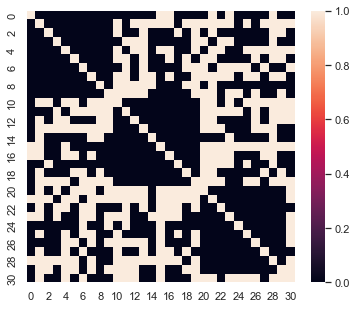

In [ ]:
sns.heatmap(occurency_matrix[:31,:31], annot=False)

# Adding: Categories

In [512]:
def add_category(base):
    base['category'] = (base['product'] / 10).astype(int)
    return base

# Adding: Probabilities (product & category)

In [513]:
def add_frequencies(base):
    prod_probs_df = (
        baskets.groupby(['customer','product'])['week'].count() / 90) \
        .reset_index() \
        .rename(columns={'week':'probability'})
        
    baskets['category'] = (baskets['product'].astype(int) / 10).astype(int)

    cat_probs_df = (
        baskets.groupby(['customer','category'])['week'].count() / 90) \
        .reset_index() \
        .rename(columns={'week':'probability'})
        
    base = pd.merge(base, prod_probs_df, on=['customer','product'] ,how='left')
    base = pd.merge(base, cat_probs_df, on=['customer','category'] ,how='left')
    base.rename(columns={'probability_x':'p_prod', 'probability_y':'p_cat'},inplace=True)
    
    return base

# Adding: Rolling frequencies

In [514]:
def get_rolling_frequencies(n_weeks=5, category=False):
    
    rolling_df = pd.DataFrame()
    
    for week_nr in range(n_weeks,89+1):

        start = week_nr - n_weeks - 1
        end = week_nr

        single_week = (
            base[(start < base['week']) & (base['week'] < end)] 
            .groupby(['customer',f"{'category' if category else 'product'}"]) 
            .agg({'week':'last','isBought':'sum'}) 
            .reset_index()
            )
        
        single_week['week'] = single_week['week'] + 1
        single_week['isBought'] = single_week['isBought'] / n_weeks
        rolling_df = pd.concat([rolling_df, single_week])
    
    return rolling_df

In [515]:
def add_rolling_frequencies(base):
    
    values = [5,10,30]
    prod_names = [f'roll_prod_{value}' for value in values]
    cat_names  = [f'roll_cat_{value}' for value in values]

    for i, name in enumerate(prod_names):
        rolled = get_rolling_frequencies(n_weeks=values[i]).rename(columns={'isBought':name})
        base = pd.merge(base, rolled, on=['week','customer','product'],how='left')

    for i, name in enumerate(cat_names):
        rolled = get_rolling_frequencies(n_weeks=values[i], category=True).rename(columns={'isBought':name})
        base2 = pd.merge(base, rolled, on=['week','customer','category'],how='left') 
        
    base.loc[:,prod_names[0]:] = base2.loc[:,prod_names[0]:].fillna(0)  
    
    return base

# Adding: Weeks since last buy (per product and per category)

In [516]:
def buy_weeks_to_ago(buy_weeks):
    weeks_past = 90
    val = []
    bought = False

    for i in range(90):
        if i in buy_weeks:
            weeks_past = 0
            val.append(weeks_past)
            bought = True
        elif(bought==True): 
            weeks_past += 1 
            val.append(weeks_past)
        else:
            val.append(90)
    return val

In [517]:
def add_week_ago(base):
    
    only_bought = base[base['isBought']==1]
    pairs = only_bought.groupby(['customer','product']).size().reset_index(inplace=False)

    all_pairs = pd.DataFrame()

    for i in range(len(pairs)):
        customer = pairs.iloc[i,0]
        product = pairs.iloc[i,1]
        
        df = pd.DataFrame({
            'week':range(90),
            'customer':customer, 
            'product':product, 
            })
        
        buy_weeks = list(only_bought[(only_bought['product']==product) & (only_bought['customer']==customer)]['week'])
        df['weeks_ago'] = buy_weeks_to_ago(buy_weeks)
        all_pairs = pd.concat([all_pairs,df])
        
    base = pd.merge(base, all_pairs, on=['week','customer','product'],how='left').fillna(90)
    
    return base

# Modelling

In [518]:
base = 

,week,customer,product,basket,price,isBought,dGiven,isGiven,isUsed
0,0,1950,0,0_1950,0,False,0,False,False
1,0,1950,1,0_1950,0,False,0,False,False
2,0,1950,2,0_1950,0,False,0,False,False
3,0,1950,3,0_1950,0,False,0,False,False
4,0,1950,4,0_1950,0,False,0,False,False
...,...,...,...,...,...,...,...,...,...
1124995,89,1999,245,89_1999,549,True,0,False,False
1124996,89,1999,246,89_1999,0,False,30,True,False
1124997,89,1999,247,89_1999,0,False,0,False,False
1124998,89,1999,248,89_1999,0,False,0,False,False


In [519]:
base3 = base2.drop(['price','isUsed','basket'],axis=1)
x_train, y_train, x_test, y_test = split_4_way(base3, target_col='isBought', unkwown_week=89)

In [520]:
base['p_prod'] = base['p_prod'].fillna(0)
base['p_cat'] = base['p_cat'].fillna(0)

base2 = base[['week','product','dGiven','isBought','isGiven','p_prod','p_cat']]
x_train, y_train, x_test, y_test = split_4_way(base2, target_col='isBought', unkwown_week=89)

KeyError: 'p_prod'

In [ ]:

model = linear_model.LogisticRegression() #0.087 - 7.3 min
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test)
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')

Will take 0m 6s ...
Loss: 0.082


In [315]:

model = ensemble.GradientBoostingClassifier() #0.071 -> 0.066
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test)
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')

Will take 1m 16s ...
Loss: 0.066


In [ ]:
#takes(153,100,n_customers)
model = ensemble.RandomForestClassifier() #0.071 -> 0.066 ->
model.fit(X=x_train,y=y_train)
predictions = model.predict_proba(x_test) 
loss = metrics.log_loss(y_test, predictions)
print(f'Loss: {round(loss,3)}')